In [65]:
%load_ext autoreload
%autoreload 2

import os

os.chdir('/home/tobias/Projects/bernoulli-mri')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
from abc import ABC, abstractmethod
from typing import Tuple

import matplotlib.pyplot as plt
from torch.optim import Adam
from tqdm import tqdm
import torch
from torch import Tensor, nn
from torchvision.transforms.functional import center_crop
from torchvision.utils import save_image

from src.config import get_configuration
from src.constraint import ScoreConstrainer
from src.dense_rate import DenseRateScheduler
from src.optimization import get_mask_handler
from src.distribution import SoftBernoulliSampler
from src.utils import (
    load_h5_slice,
    get_temperature,
    ifft2c,
    fft2c,
    plot_heatmap,
    min_max_normalize,
)
from src.datasets import ACDCDataset
from src.losses import SobelMSELoss

In [67]:
BASE_CONFIG = {
    'file_path': 'data/ACDC',
    'slice_idx': 17,
    'coil_idx': None,
    'cropping': (320, 320),
    'steps': 5000,
    'learning_rate': 1e-2,
    'bern_samples': 4,
    'mask_style': 'f',
    'dense_target': 1 / 8,
    'dense_start': 0.10,
    'dense_end': 0.85,
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'log_dir': 'logs/acdc',
    'log_imgs': 10,
}

cfg = get_configuration(BASE_CONFIG)

In [68]:
#loss_func = nn.MSELoss()
loss_func = SobelMSELoss(alpha=0.1).to(cfg.device)
#loss_func = nn.MSELoss(reduction='none')

In [69]:
dense_scheduler = DenseRateScheduler(
            target=cfg.dense_target,
            start_epoch=int(cfg.dense_start * cfg.steps),
            stop_epoch=int(cfg.dense_end * cfg.steps),
        )

In [70]:
acdc = ACDCDataset(cfg.file_path, train=True)

sample = acdc[42]
img = sample['img']
img_k = sample['k_space']

seg_weight = 1
seg = sample['seg']
seg[seg != 0] = seg_weight
seg[seg == 0] = 1
seg = seg.to(cfg.device)

L: 4.72E-02 | D: 0.125: 100%|██████████| 5000/5000 [00:41<00:00, 121.02it/s]


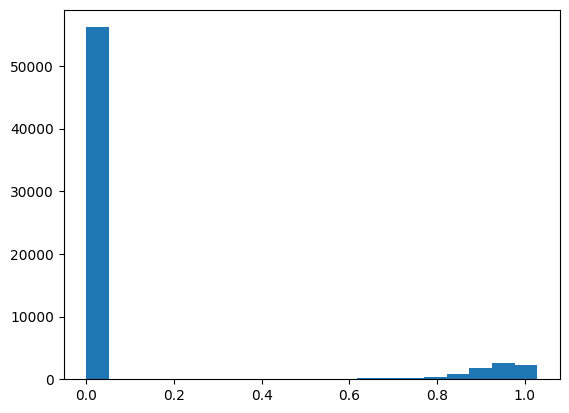

In [71]:
img = img.unsqueeze(0).to(cfg.device)
img_k = img_k.unsqueeze(0).to(cfg.device)

img_low_q = torch.quantile(img, 0.01)
img_high_q = torch.quantile(img, 0.99)

# Create mask handler that also contains scores
mask_handler = get_mask_handler(
    name=cfg.mask_style,
    height=img.shape[-2],
    width=img.shape[-1],
    device=cfg.device,
)

# Initialize optimizer with mask scores
optimizer = Adam([mask_handler.get_scores()], lr=cfg.learning_rate)

# Create constrainer for projection of scores to dense_rate
constrainer = ScoreConstrainer(mask_handler.get_scores())

log_recs = []
log_masks = []

for step in (pbar := tqdm(range(1, cfg.steps + 1))):

    # Get temperature for categorical "softness"
    temperature = get_temperature(step, cfg.steps)

    # Map scores to valid probability space
    dense_rate = dense_scheduler.get_dense_rate()
    constrainer.constrain(dense_rate=dense_rate)
    dense_scheduler.advance()

    # Sample from distribution
    mask = mask_handler.sample_mask(
        temperature=temperature, num_samples=cfg.bern_samples
    )

    # Compute image with mask
    img_pred = ifft2c(img_k * mask + 0.0)
    img_mag = torch.abs(img_pred)

    # Compute loss between full and undersampled image
    img_batch = img.expand(cfg.bern_samples, -1, -1, -1)
    loss = loss_func(img_mag, img_batch)

    #loss *= seg
    #loss = torch.mean(loss)

    # Optimize scores
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if step % 20 == 0:
        pbar.set_description(
            'L: {:.2E} | D: {:.3f}'.format(
                float(loss), float(torch.mean(mask_handler.get_scores()))
            )
        )

    num_imgs = cfg.log_imgs
    if num_imgs > 0 and step % (cfg.steps // num_imgs) == 0:
        img_rec = torch.abs(img_pred[0])
        img_rec = min_max_normalize(img_rec, img_low_q, img_high_q)

        log_recs.append(img_rec.detach().cpu())
        log_masks.append(mask[0].detach().cpu())

# ------------------------------------------------------------------------------

# Construct training progress grid
os.makedirs(cfg.log_dir, exist_ok=True)
img_org = min_max_normalize(img, img_low_q, img_high_q)
log_recs.append(img_org.squeeze(0).cpu())
log_masks.append(torch.zeros_like(img).squeeze(0).cpu())

save_image(
    log_recs + log_masks,
    fp=cfg.log_dir + '/progress.png',
    nrow=len(log_recs),
)

# Construct heatmap
plot_heatmap(
    mask_handler.get_mask_distribution(),
    save_path=cfg.log_dir + '/heatmap.png',
)

# Construct histogram of scores
plt.hist(mask_handler.get_scores().detach().cpu().flatten(), bins=20)
plt.savefig(cfg.log_dir + '/histogram.png')